# Import

In [1]:
import numpy as np
import pandas as pd
from math import sqrt 
import matplotlib.pyplot as plt 
from matplotlib import rcParams
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


%matplotlib inline
#%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)


2.9.1


## load dataset

In [2]:
dataset = pd.read_csv('eMalahleniIM.csv', sep =';', header=0, index_col=0)
values = dataset.values

## Plot pm2.5

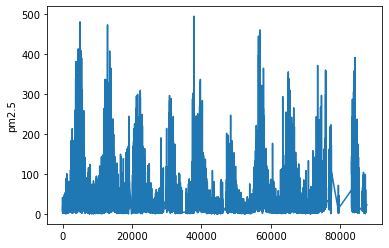

In [3]:
plt.plot(values[:,0])
plt.ylabel(dataset.columns[0])
plt.show()

## Data preparation

We need a way to prepare the data for whatever way we would like to formulate the problem.

In this case we are formulating it such that we take in 1 time step input (14 variables) and output 1 time step output (1 variable). In other words we are trying to solve the following question: given the pollution and weather conditions of the previous hour, can we predict the PM2.5 level for the next hour.

The single variable we are outputing is the PM2.5 level. Note we also use PM2.5 level in our input.

Credit for this code: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Get column names

In [5]:
dataset.columns

Index(['pm2.5', 'pm10', 'so2', 'no2', 'no', 'nox', 'o3', 'co', 'ws', 'wd',
       'temp', 'relHum', 'pressure'],
      dtype='object')

##Actually perform the data preparation

We scale the values between 0 and 1.

The code which converts the data into the suitable way we want, in this case, will produce 14 output variables. In our case we only want to predict PM2.5, that is why we drop the other collumns from the dataframe.

Credit for this code: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [6]:
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
# We drop these because we are only interested in predicting for a single variable (PM2.5).
# If we don't drop, then we will be predicting for all the variables too!
reframed.drop(reframed.columns[[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]], axis=1, inplace=True)
values = reframed.values

## View the data

In [7]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var1(t)
1,0.018966,0.016509,0.017832,0.023121,0.007442,0.015058,0.380849,0.004532,0.487526,0.493486,0.546332,0.833146,0.549068,0.026136
2,0.026136,0.016882,0.069390,0.088378,0.006463,0.036362,0.334627,0.003827,0.455301,0.539821,0.503610,0.942542,0.561046,0.038245
3,0.038245,0.024513,0.104785,0.121924,0.008580,0.049843,0.225011,0.024270,0.373181,0.403761,0.495473,0.916471,0.562208,0.015315
4,0.015315,0.009721,0.035120,0.013445,0.005276,0.009682,0.431832,0.022155,0.505198,0.313120,0.492930,0.856865,0.545851,0.010145
5,0.010145,0.006823,0.022419,0.026773,0.006716,0.015604,0.408700,0.006143,0.279626,0.275397,0.513782,0.789183,0.537181,0.023049


## Create X and Y variables

In [8]:
values.shape

(87645, 14)

In [9]:
X = values[:,:-1]

In [10]:
Y = values[:,-1]

## Check the shapes

In [11]:
X.shape

(87645, 13)

In [12]:
Y.shape

(87645,)

## Reshaping

reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]

In [13]:
X = X.reshape(X.shape[0],1,1,X.shape[1])

In [14]:
X.shape

(87645, 1, 1, 13)

## Training, validation and testing split

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

## Check the shape

In [16]:
print ('X_train:',X_train.shape)
print ('Y_train:',Y_train.shape)
print ()
print ('X_val:',X_val.shape)
print ('Y_val:',Y_val.shape)
print ()
print ('X_test:',X_test.shape)
print ('Y_test:',Y_test.shape)

X_train: (56092, 1, 1, 13)
Y_train: (56092,)

X_val: (14024, 1, 1, 13)
Y_val: (14024,)

X_test: (17529, 1, 1, 13)
Y_test: (17529,)


## Define a model
Credit for this code: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [17]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 1, 13)))
model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(56, input_shape=(1, 13)))
model.add(Dense(56, activation="relu"))
model.add(Dense(56, activation="relu"))
model.add(Dense(56, activation="relu"))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='mse', optimizer='adam')

## Print summary

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 1, 64)      896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 1, 64)      4160      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 1, 64)      4

## Training

In [19]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, batch_size=32, verbose=1)

Epoch 1/40
1753/1753 [==============================] - 70s 37ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 2/40
1753/1753 [==============================] - 67s 38ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 3/40
1753/1753 [==============================] - 67s 38ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/40
1753/1753 [==============================] - 70s 40ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/40
1753/1753 [==============================] - 71s 40ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/40
1753/1753 [==============================] - 68s 39ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/40
1753/1753 [==============================] - 72s 41ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/40
1753/1753 [==============================] - 73s 42ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/40
1753/1753 [==============================] - 76s 43ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/40
1753/1753 [==============================] - 76s 43m

# Plot the performance

## Predict

In [20]:
prediction = model.predict(X_test)

548/548 [==============================] - 3s 4ms/step


In [21]:
def unscale(scaled_value):
    # if target variable is the first column, then, data_max_[0]
    unscaled_value = scaled_value * (scaler.data_max_[0] - scaler.data_min_[0]) + (scaler.data_min_[0])
    return unscaled_value

In [22]:
predictions = unscale(prediction)

In [23]:
Y_tests = unscale(Y_test)

# Plot the performance

In [ ]:
mean_absolute_error(Y_tests, predictions)

In [ ]:
rmse = sqrt(mean_squared_error(Y_tests, predictions))
print(rmse)

In [ ]:
r2_score(Y_tests, predictions)

In [ ]:
print('accuracy testing = {}'.format(np.sum(prediction==Y_test)) )

## Compare prediction and testing data

In [ ]:
rcParams['font.weight'] = 'bold'
plt.plot(Y_tests[0:240], color='blue', label = 'Observed')
plt.plot(predictions[0:240], color='red', label = 'Predicted')
plt.ylabel('SO2', fontname="Times New Roman", size=20,fontweight="bold")
plt.xlabel('Time(Hrs)', fontname="Times New Roman", size=20,fontweight="bold")
plt.title('Secunda CNNLSTM', fontname="Times New Roman", size=28,fontweight="bold")
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties)
plt.show()

In [ ]:
## Calculate errors
errors = predictions.flatten() - Y_tests

# Calculate quantiles based on actual values
quantiles, bins = pd.qcut(Y_tests, q=10, duplicates='drop', retbins=True)

# Calculate average error for each quantile
quantile_errors = []
for i in range(len(bins) - 1):
    group_indices = np.where((Y_tests >= bins[i]) & (Y_tests < bins[i+1]))[0]
    quantile_errors.append(errors[group_indices].mean())

# Plot quantiles vs. average errors
rcParams['font.weight'] = 'bold'
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(quantiles.categories) + 1), quantile_errors, marker='o')
plt.xlabel('Quantile', fontname="Times New Roman", size=20,fontweight="bold")
plt.ylabel('Average Error', fontname="Times New Roman", size=20,fontweight="bold")
plt.title('Quantile Analysis', fontname="Times New Roman", size=28,fontweight="bold")
plt.xticks(range(1, len(quantiles.categories) + 1), [str(q) for q in quantiles.categories], rotation=45)
plt.grid(True)
plt.show()

In [ ]:
errors = predictions.flatten() - Y_tests

# Calculate quantiles based on actual values
quantiles, bins = pd.qcut(Y_tests, q=10, duplicates='drop', retbins=True)

# Calculate average error for each quantile
quantile_errors = []
for i in range(len(bins) - 1):
    group_indices = np.where((Y_tests >= bins[i]) & (Y_tests < bins[i+1]))[0]
    quantile_errors.append(errors[group_indices].mean())

# Round the bin edges for better readability
rounded_bins = np.round(bins, decimals=3)

# Plot quantiles vs. average errors
rcParams['font.weight'] = 'bold'
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(quantiles.categories) + 1), quantile_errors, marker='o')
plt.xlabel('Quantile', fontname="Times New Roman", size=20, fontweight="bold")
plt.ylabel('Average Error', fontname="Times New Roman", size=20, fontweight="bold")
plt.title('Quantile Analysis', fontname="Times New Roman", size=28, fontweight="bold")
plt.xticks(range(1, len(quantiles.categories) + 1), [f'{rounded_bins[i]:.3f} - {rounded_bins[i+1]:.3f}' for i in range(len(rounded_bins) - 1)], rotation=45)
plt.grid(True)
plt.show()

# SAVE THE MODEL

In [ ]:
# eMalahleni PM2.5
#model.save('lstmcnn_model.h5')
model.save('lstmcnn_modelPM1.h5')
#model.save('lstmcnn_modelSO2.h5')
#model.save('lstmcnn_modelNO2.h5')

In [ ]:
# Ermelo PM2.5
#model.save('lstmcnn_modelEPM2.h5')
#model.save('lstmcnn_modelEPM1.h5')
#model.save('lstmcnn_modelESO2.h5')
model.save('lstmcnn_modelENO2.h5')

In [ ]:
# Hendrina PM2.5
#model.save('lstmcnn_modelHPM2.h5')
#model.save('lstmcnn_modelHPM1.h5')
#model.save('lstmcnn_modelHSO2.h5')
model.save('lstmcnn_modelHNO2.h5')

In [ ]:
# Middelburg PM2.5
model.save('lstmcnn_modelMPM2.h5')
#model.save('lstmcnn_modelMPM1.h5')
#model.save('lstmcnn_modelMSO2.h5')
#model.save('lstmcnn_modelMNO2.h5')

In [ ]:
# Secunda PM2.5
#model.save('lstmcnn_modelSPM2.h5')
#model.save('lstmcnn_modelSPM1.h5')
#model.save('lstmcnn_modelSSO2.h5')
model.save('lstmcnn_modelSNO2.h5')


# Forecasting

In [32]:
DFforecast = pd.read_csv('eMalahleniIM48.csv', sep =';', header=0, index_col=0)
values = DFforecast.values

In [33]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [34]:
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
# We drop these because we are only interested in predicting for a single variable (PM2.5).
# If we don't drop, then we will be predicting for all the variables too!
reframed.drop(reframed.columns[[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]], axis=1, inplace=True)
values = reframed.values

In [35]:
X_Forecast = values[:,:-1]

In [36]:
Y_Forecast = values[:,-1]

In [37]:
X_Forecast = X_Forecast.reshape(X_Forecast.shape[0],1,1,X_Forecast.shape[1])

In [38]:
Forecast = model.predict(X_Forecast)

2/2 [==============================] - 0s 6ms/step


In [39]:
Forecasts = unscale(Forecast)

In [40]:
Y_Forecasts = unscale(Y_Forecast)

In [48]:
mean_absolute_error(Y_Forecasts[0:1], Forecasts[0:1])

26.463936

In [49]:
mean_absolute_error(Y_Forecasts[6:12], Forecasts[6:12])

17.090403

In [50]:
mean_absolute_error(Y_Forecasts[12:18], Forecasts[12:18])

2.9636402

In [51]:
mean_absolute_error(Y_Forecasts[18:24], Forecasts[18:24])

5.6635284

In [46]:
mean_absolute_error(Y_Forecasts[24:36], Forecasts[24:36])

3.6686828

In [47]:
mean_absolute_error(Y_Forecasts[36:48], Forecasts[36:48])

7.5857487

In [52]:
rmse = sqrt(mean_squared_error(Y_Forecasts[0:6], Forecasts[0:6]))
print(rmse)

33.81824877481554


In [53]:
rmse = sqrt(mean_squared_error(Y_Forecasts[6:12], Forecasts[6:12]))
print(rmse)

18.69776251967565


In [54]:
rmse = sqrt(mean_squared_error(Y_Forecasts[12:18], Forecasts[12:18]))
print(rmse)

3.6843641492895776


In [55]:
rmse = sqrt(mean_squared_error(Y_Forecasts[18:24], Forecasts[18:24]))
print(rmse)

6.927450788881365


In [56]:
rmse = sqrt(mean_squared_error(Y_Forecasts[24:36], Forecasts[24:36]))
print(rmse)

5.016380752239649


In [57]:
rmse = sqrt(mean_squared_error(Y_Forecasts[36:48], Forecasts[36:48]))
print(rmse)

10.791135639886912


In [24]:
combinedArray = np.column_stack((Y_tests[0:240],predictions[0:240]))
print("Actual PM2.5   Predicted PM2.5")
s = [[str(e) for e in row] for row in np.around(combinedArray, 2)]
lens = [max(map(len, col)) for col in zip(*s)]
fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
table = [fmt.format(*row) for row in s]
print ('\n'.join(table))

Actual PM2.5   Predicted PM2.5
35.58 	33.06 
12.2  	10.73 
40.73 	40.95 
12.18 	5.19  
23.46 	15.39 
5.78  	4.47  
47.82 	41.18 
4.65  	4.43  
14.72 	11.17 
10.27 	8.38  
40.53 	44.82 
3.96  	4.67  
23.34 	21.14 
4.8   	9.68  
92.36 	81.65 
116.86	102.37
14.37 	11.28 
4.88  	12.07 
17.7  	16.08 
26.88 	36.68 
42.69 	35.47 
11.97 	11.58 
40.13 	23.89 
34.35 	33.22 
14.65 	10.88 
17.49 	17.78 
43.27 	35.12 
93.07 	67.43 
17.72 	17.51 
12.4  	14.69 
8.34  	5.61  
31.53 	23.13 
13.36 	23.07 
47.95 	54.93 
10.72 	10.03 
9.72  	17.29 
16.62 	14.62 
3.56  	12.56 
19.05 	13.19 
14.26 	13.98 
6.04  	6.55  
130.51	85.91 
4.06  	8.29  
71.23 	57.69 
4.43  	4.59  
17.48 	17.22 
13.0  	20.55 
3.09  	3.1   
60.21 	65.22 
6.51  	7.35  
10.48 	9.45  
148.67	57.39 
54.33 	54.49 
14.89 	12.89 
19.12 	20.1  
23.72 	57.67 
57.14 	24.14 
9.45  	10.55 
8.15  	8.96  
25.02 	14.09 
8.19  	10.95 
10.95 	20.23 
26.8  	58.5  
8.5   	7.74  
54.64 	59.32 
40.32 	36.84 
1.52  	3.53  
23.65 	34.36 
6.25  	7.35  
15.

56.44 	33.23 
